In [4]:
import os
import numpy as np
import glob
import PIL.Image as Image

# pip install torchsummary
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

import matplotlib.pyplot as plt
from IPython.display import clear_output
import xml.etree.ElementTree as ET
import matplotlib.patches as patches

In [5]:
data_path = "/zhome/c0/9/155094/courses/computer_vision/pothole_project_git/Detection_deeplearning_in_computervision/Potholes/Potholes/annotated-images"

In [6]:
class PotholeDataset(torch.utils.data.Dataset):
    def __init__(self, data_path):
        self.data_path = data_path
        self.image_paths = []
        self.annotations = []
        self.load_data()
        
    def load_data(self):
        for filename in os.listdir(self.data_path):
            if filename.endswith('.xml'):
                annotation_path = os.path.join(self.data_path, filename)
                annotation = self.parse_annotation(annotation_path)
                
                image_filename = annotation['filename']
                image_path = os.path.join(self.data_path, image_filename)
                
                if os.path.exists(image_path):
                    self.image_paths.append(image_path)
                    self.annotations.append(annotation)
                else:
                    print(f"Warning: Image {image_filename} not found for annotation {filename}")
                    
    def parse_annotation(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        
        annotation = {
            'filename': root.find('filename').text,
            'path': root.find('path').text,
            'size': {
                'width': int(root.find('size/width').text),
                'height': int(root.find('size/height').text),
                'depth': int(root.find('size/depth').text)
            },
            'objects': []
        }
        
        for obj in root.findall('object'):
            obj_info = {
                'name': obj.find('name').text,
                'bndbox': {
                    'xmin': int(obj.find('bndbox/xmin').text),
                    'ymin': int(obj.find('bndbox/ymin').text),
                    'xmax': int(obj.find('bndbox/xmax').text),
                    'ymax': int(obj.find('bndbox/ymax').text)
                }
            }
            annotation['objects'].append(obj_info)
            
        return annotation

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        annotation = self.annotations[idx]
        
        image = Image.open(image_path)
        image = np.array(image)
        
        return image, annotation


In [10]:
# Usage example:
data_path = "Potholes/Potholes/annotated-images"
dataset = PotholeDataset(data_path)
print(f"Loaded {len(dataset)} images with annotations.")
image, annotation = dataset[0]
print("Image shape:", image.shape)
print("Annotation:", annotation)


Loaded 665 images with annotations.
Image shape: (300, 303, 3)
Annotation: {'filename': 'img-621.jpg', 'path': '/CSE-800/Thesis/2020-01-23/dataset/img-621.jpg', 'size': {'width': 303, 'height': 300, 'depth': 3}, 'objects': [{'name': 'pothole', 'bndbox': {'xmin': 198, 'ymin': 146, 'xmax': 240, 'ymax': 183}}, {'name': 'pothole', 'bndbox': {'xmin': 7, 'ymin': 44, 'xmax': 114, 'ymax': 117}}, {'name': 'pothole', 'bndbox': {'xmin': 1, 'ymin': 25, 'xmax': 49, 'ymax': 40}}, {'name': 'pothole', 'bndbox': {'xmin': 147, 'ymin': 45, 'xmax': 214, 'ymax': 69}}, {'name': 'pothole', 'bndbox': {'xmin': 224, 'ymin': 65, 'xmax': 287, 'ymax': 87}}, {'name': 'pothole', 'bndbox': {'xmin': 3, 'ymin': 158, 'xmax': 45, 'ymax': 221}}]}


Image shape: (300, 303, 3)
Annotation: {'filename': 'img-621.jpg', 'path': '/CSE-800/Thesis/2020-01-23/dataset/img-621.jpg', 'size': {'width': 303, 'height': 300, 'depth': 3}, 'objects': [{'name': 'pothole', 'bndbox': {'xmin': 198, 'ymin': 146, 'xmax': 240, 'ymax': 183}}, {'name': 'pothole', 'bndbox': {'xmin': 7, 'ymin': 44, 'xmax': 114, 'ymax': 117}}, {'name': 'pothole', 'bndbox': {'xmin': 1, 'ymin': 25, 'xmax': 49, 'ymax': 40}}, {'name': 'pothole', 'bndbox': {'xmin': 147, 'ymin': 45, 'xmax': 214, 'ymax': 69}}, {'name': 'pothole', 'bndbox': {'xmin': 224, 'ymin': 65, 'xmax': 287, 'ymax': 87}}, {'name': 'pothole', 'bndbox': {'xmin': 3, 'ymin': 158, 'xmax': 45, 'ymax': 221}}]}


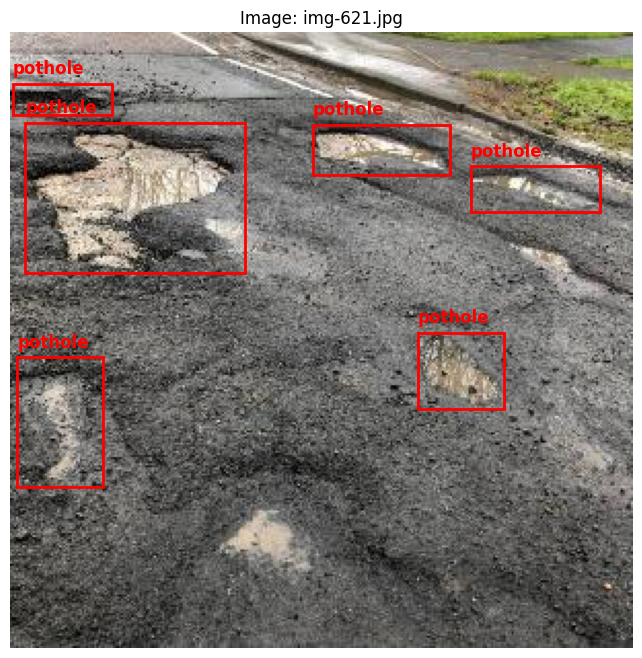

Image shape: (300, 480, 3)
Annotation: {'filename': 'img-577.jpg', 'path': '/CSE-800/Thesis/2020-01-23/dataset/img-577.jpg', 'size': {'width': 480, 'height': 300, 'depth': 3}, 'objects': [{'name': 'pothole', 'bndbox': {'xmin': 37, 'ymin': 154, 'xmax': 235, 'ymax': 234}}, {'name': 'pothole', 'bndbox': {'xmin': 104, 'ymin': 120, 'xmax': 141, 'ymax': 132}}, {'name': 'pothole', 'bndbox': {'xmin': 35, 'ymin': 241, 'xmax': 96, 'ymax': 300}}, {'name': 'pothole', 'bndbox': {'xmin': 274, 'ymin': 194, 'xmax': 342, 'ymax': 237}}, {'name': 'pothole', 'bndbox': {'xmin': 313, 'ymin': 242, 'xmax': 354, 'ymax': 283}}, {'name': 'pothole', 'bndbox': {'xmin': 361, 'ymin': 227, 'xmax': 419, 'ymax': 270}}, {'name': 'pothole', 'bndbox': {'xmin': 359, 'ymin': 182, 'xmax': 437, 'ymax': 218}}, {'name': 'pothole', 'bndbox': {'xmin': 366, 'ymin': 146, 'xmax': 479, 'ymax': 189}}, {'name': 'pothole', 'bndbox': {'xmin': 322, 'ymin': 126, 'xmax': 363, 'ymax': 150}}, {'name': 'pothole', 'bndbox': {'xmin': 339, 'ymin'

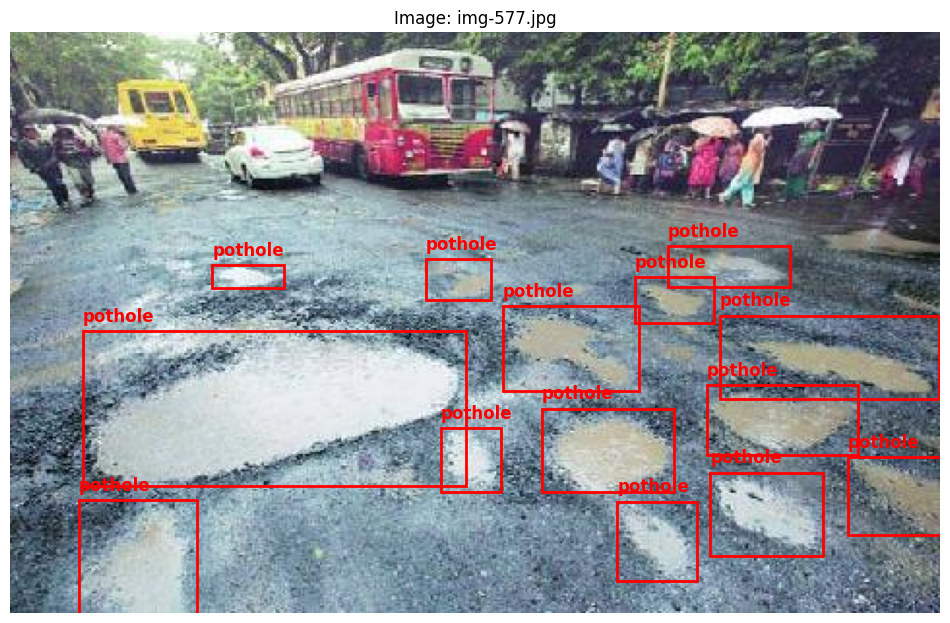

Image shape: (300, 400, 3)
Annotation: {'filename': 'img-338.jpg', 'path': '/CSE-800/Thesis/2020-01-23/dataset/img-338.jpg', 'size': {'width': 400, 'height': 300, 'depth': 3}, 'objects': [{'name': 'pothole', 'bndbox': {'xmin': 62, 'ymin': 74, 'xmax': 370, 'ymax': 257}}]}


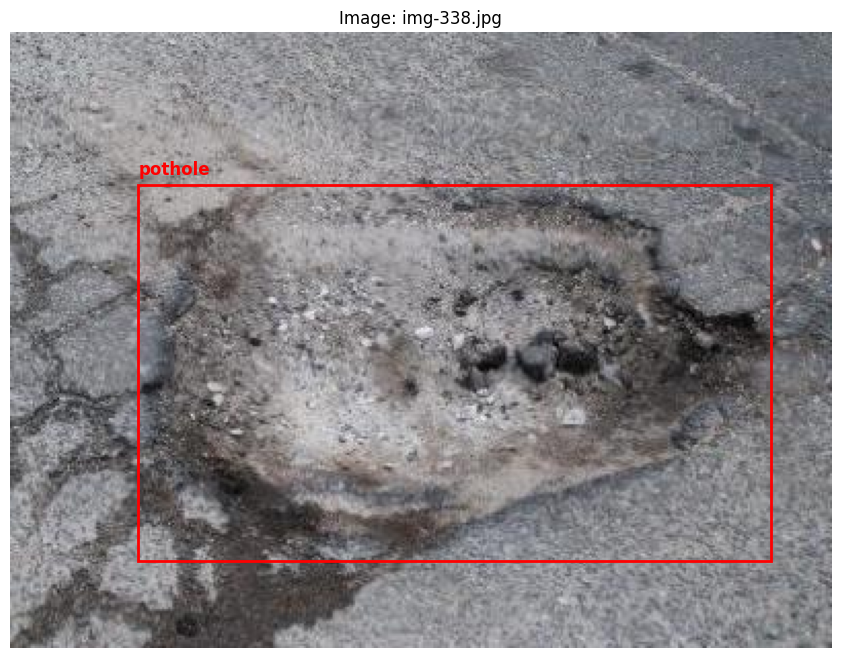

Image shape: (300, 400, 3)
Annotation: {'filename': 'img-561.jpg', 'path': '/CSE-800/Thesis/2020-01-23/dataset/img-561.jpg', 'size': {'width': 400, 'height': 300, 'depth': 3}, 'objects': [{'name': 'pothole', 'bndbox': {'xmin': 176, 'ymin': 38, 'xmax': 212, 'ymax': 52}}, {'name': 'pothole', 'bndbox': {'xmin': 190, 'ymin': 5, 'xmax': 247, 'ymax': 25}}, {'name': 'pothole', 'bndbox': {'xmin': 279, 'ymin': 1, 'xmax': 400, 'ymax': 161}}, {'name': 'pothole', 'bndbox': {'xmin': 20, 'ymin': 87, 'xmax': 298, 'ymax': 191}}, {'name': 'pothole', 'bndbox': {'xmin': 61, 'ymin': 201, 'xmax': 179, 'ymax': 300}}, {'name': 'pothole', 'bndbox': {'xmin': 2, 'ymin': 231, 'xmax': 44, 'ymax': 255}}, {'name': 'pothole', 'bndbox': {'xmin': 163, 'ymin': 57, 'xmax': 191, 'ymax': 76}}, {'name': 'pothole', 'bndbox': {'xmin': 124, 'ymin': 70, 'xmax': 160, 'ymax': 87}}, {'name': 'pothole', 'bndbox': {'xmin': 339, 'ymin': 163, 'xmax': 400, 'ymax': 193}}]}


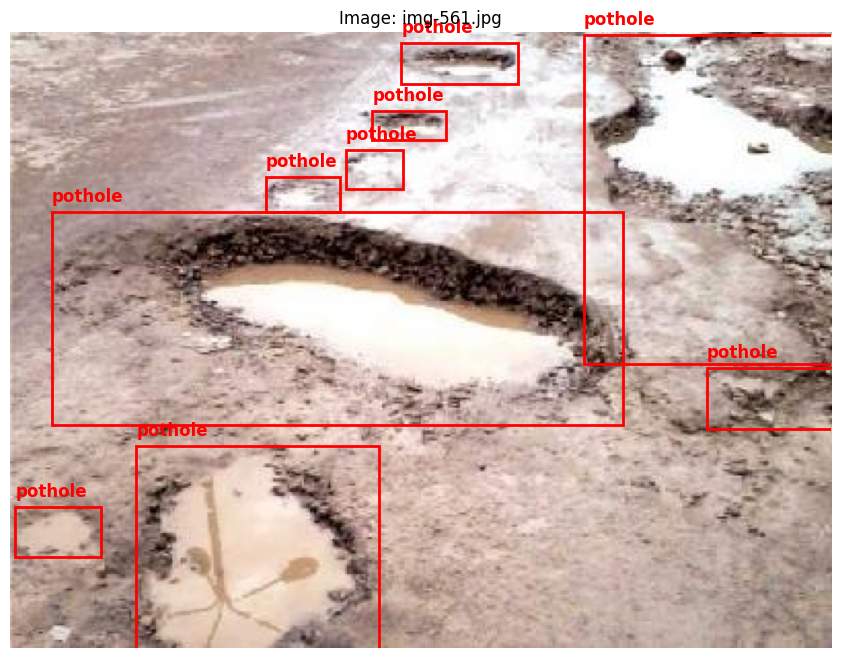

Image shape: (300, 455, 3)
Annotation: {'filename': 'img-455.jpg', 'path': '/CSE-800/Thesis/2020-01-23/dataset/img-455.jpg', 'size': {'width': 455, 'height': 300, 'depth': 3}, 'objects': [{'name': 'pothole', 'bndbox': {'xmin': 266, 'ymin': 109, 'xmax': 323, 'ymax': 138}}]}


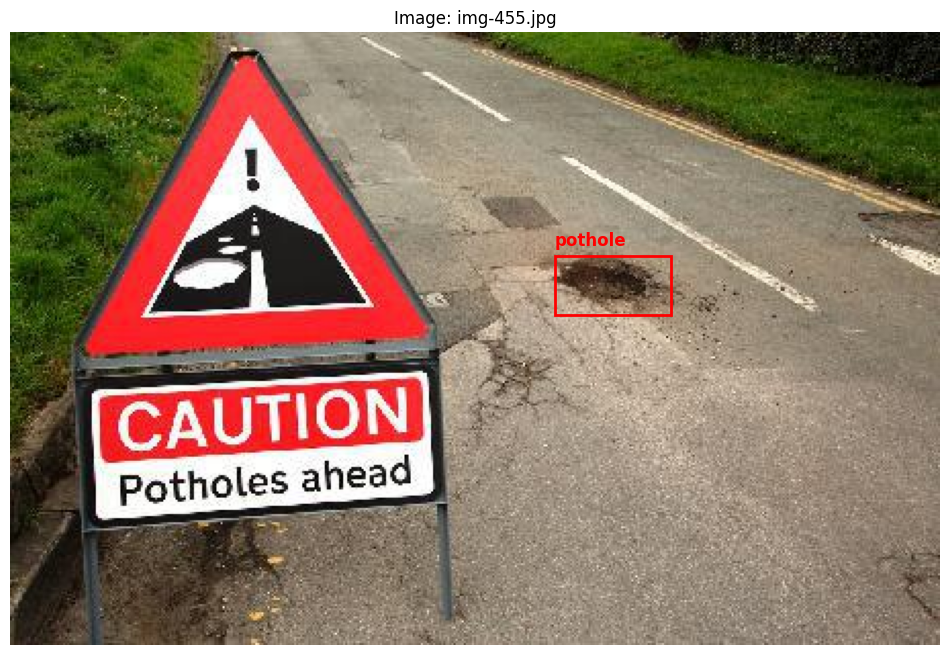

In [11]:
# Function to plot an image with bounding boxes
def plot_image_with_bboxes(image, annotation):
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.imshow(image)

    for obj in annotation['objects']:
        bbox = obj['bndbox']
        xmin = bbox['xmin']
        ymin = bbox['ymin']
        xmax = bbox['xmax']
        ymax = bbox['ymax']
        width = xmax - xmin
        height = ymax - ymin

        # Create a Rectangle patch
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)
        
        # Add label
        ax.text(xmin, ymin - 5, obj['name'], color='red', fontsize=12, weight='bold')

    plt.title(f"Image: {annotation['filename']}")
    plt.axis('off')
    plt.show()

# Plot the first 5 images with their bounding boxes
for idx in range(5):
    image, annotation = dataset[idx]
    print(f"Image shape: {image.shape}")
    print(f"Annotation: {annotation}")
    plot_image_with_bboxes(image, annotation)